In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.preprocessing import BoxCoxEndogTransformer

# Get Data

In [ ]:
data = sns.load_dataset("flights")
data["date"] = pd.to_datetime(
    data["year"].astype(str) + "-" + data["month"].astype(str)
)

ts = data.set_index("date")["passengers"]
ts.head()

/var/folders/vx/bt98j0q121dd2w3k6_lm79k40000gn/T/ipykernel_45729/3303159713.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["date"] = pd.to_datetime(


date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: passengers, dtype: int64

# Descomposición de la Serie

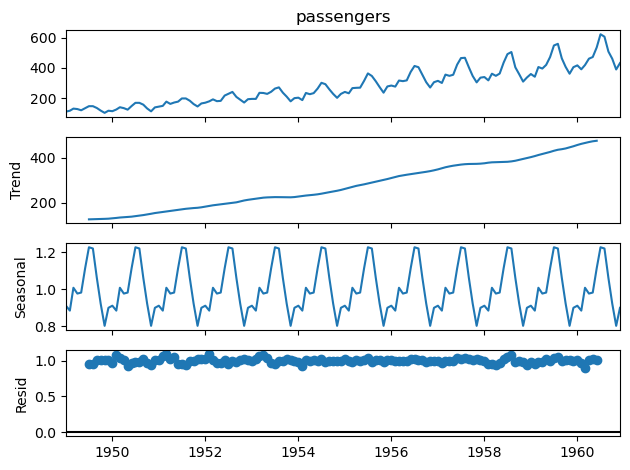

In [4]:
decomp = seasonal_decompose(ts, model="multiplicative", period=12)
decomp.plot();

# Estabilización de la Varianza

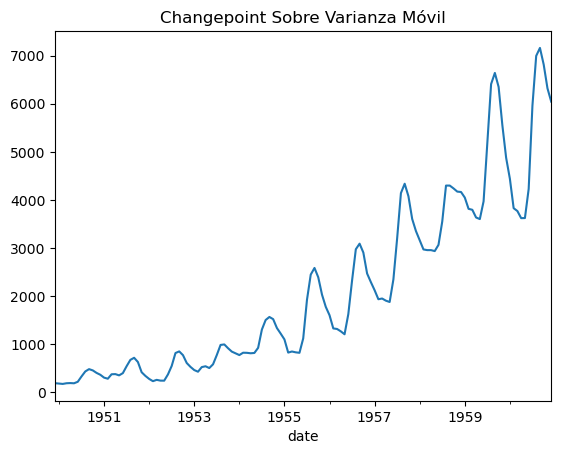

In [5]:
rolling_var = ts.rolling(window=12).var().dropna()
rolling_var.plot().set_title("Changepoint Sobre Varianza Móvil");

In [16]:
def guerrero_lambda(ts, m=12, lambdas=np.linspace(-2, 2, 300)):
    ts = ts.dropna().values
    ts = ts[ts > 0]  # Box–Cox requiere positivos

    blocks = np.array_split(ts, len(ts)//m)
    scores = []

    for lam in lambdas:
        stds = []
        for b in blocks:
            bt = boxcox(b, lam)
            stds.append(np.std(bt, ddof=1))

        stds = np.array(stds)
        score = np.std(np.log(stds)) / np.mean(np.log(stds))
        scores.append(score)

    return lambdas[np.argmin(scores)]

lam = guerrero_lambda(ts, m=12)
print('Lambda que minimiza CV (Gerrero): ' + lam.astype(str))


Lambda que minimiza CV (Gerrero): 0.35451505016722384


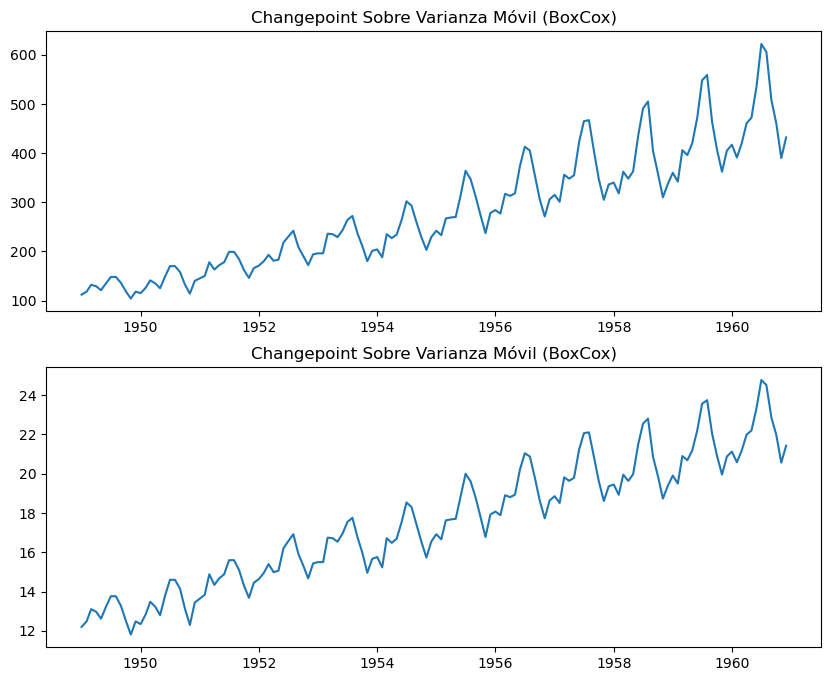

In [36]:
ts_bc = boxcox(ts, lam)
ts_bc = pd.Series(ts_bc, index=ts.index)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(ts); axes[0].set_title("Changepoint Sobre Varianza Móvil (BoxCox)")
axes[1].plot(ts_bc); axes[1].set_title("Changepoint Sobre Varianza Móvil (BoxCox)");

# Estabilización de la Media

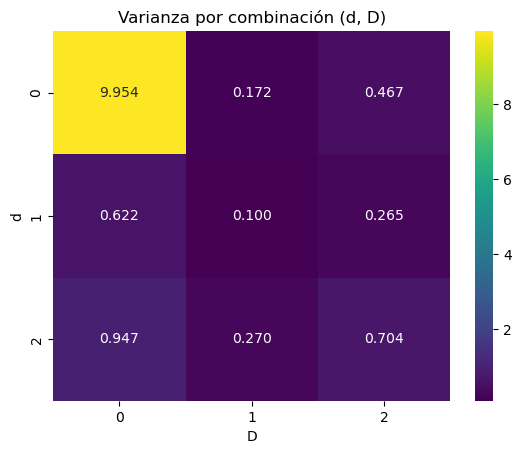

In [35]:
def difference_series(ts, d=0, D=0, s=12):
    ts_diff = ts.copy()

    for _ in range(d):
        ts_diff = ts_diff.diff()

    for _ in range(D):
        ts_diff = ts_diff.diff(s)

    return ts_diff.dropna()


results = []

for d in range(3):
    for D in range(3):
        ts_d = difference_series(ts_bc, d=d, D=D, s=12)
        var = ts_d.var()
        results.append({"d": d, "D": D, "variance": var})

df_results = pd.DataFrame(results).sort_values("variance")

pivot = df_results.pivot(index="d", columns="D", values="variance")
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Varianza por combinación (d, D)")
plt.show()


In [27]:
s = 12

# d = 1
ts_d = ts_bc.diff()

# D = 1
ts_dD = ts_d.diff(s)

ts_dD = ts_dD.dropna()


## Chequeo de Estacionariedad De Media

In [31]:
def check_stationarity(x, name="serie"):
    adf = adfuller(x.dropna())

    print(f"--- {name} ---")
    print(f"ADF p-value  : {adf[1]:.4f}")

check_stationarity(ts_dD, 'Serie con lambda:0.354, d:1, D:1')
print('Es estacionaria')

--- Serie con lambda:0.354, d:1, D:1 ---
ADF p-value  : 0.0004
Es estacionaria


# Evolución de la Serie

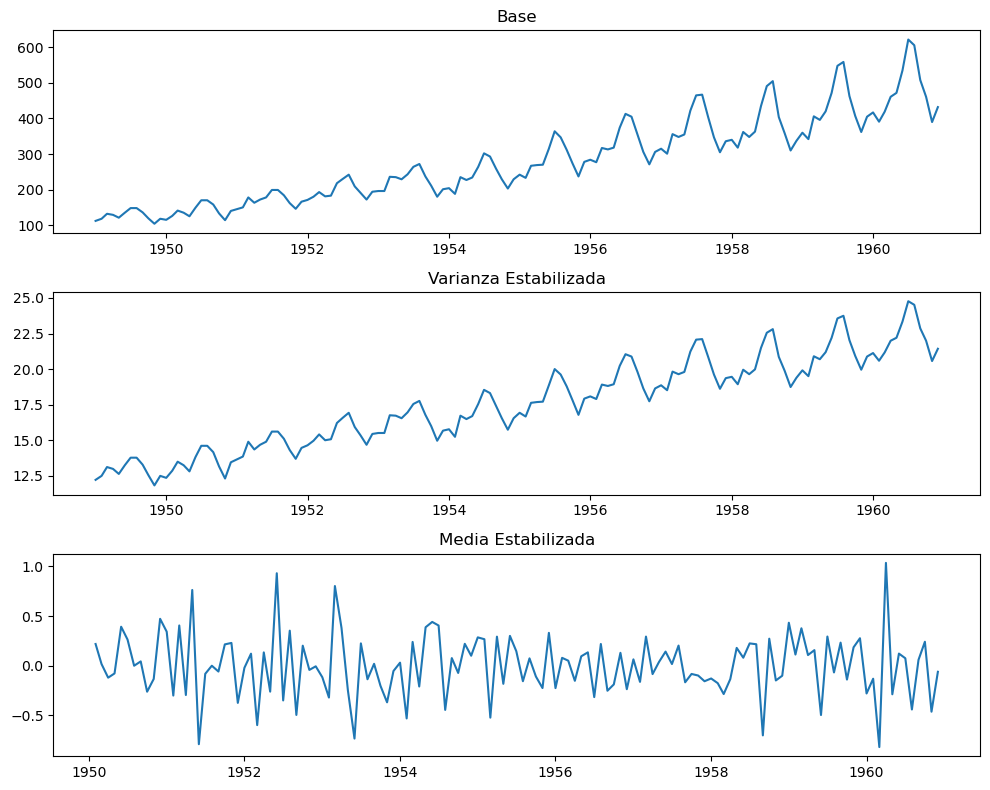

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(ts); axes[0].set_title("Base")
axes[1].plot(ts_bc); axes[1].set_title("Varianza Estabilizada")
axes[2].plot(ts_dD); axes[2].set_title("Media Estabilizada")
plt.tight_layout()